In [25]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [26]:
crypto = "FET"
timeframe = "15m"
df = pd.read_csv(f"data/{crypto}.csv")
df["timestamp"] = [int(datetime.timestamp(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))) for x in df["datetime"]]
df.set_index('timestamp', inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

In [27]:
# Extract features and target
times = df.index.astype(int) // (df.index[1] - df.index[0])
print(times)

Index([1890456, 1890457, 1890458, 1890459, 1890460, 1890461, 1890462, 1890463,
       1890464, 1890465,
       ...
       1892462, 1892463, 1892464, 1892465, 1892466, 1892467, 1892468, 1892469,
       1892470, 1892471],
      dtype='int32', name='timestamp', length=2016)


In [28]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['open', 'volume', 'high', 'low', 'hourly']
num_features = len(features)
df_scaled = scaler.fit_transform(df[features])

In [29]:
# Function to create input sequences and labels
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)


# Set the sequence length
sequence_length = 16

In [30]:
# Create sequences and labels
X, y = create_sequences(df_scaled, sequence_length)
print(X.shape)
print(y.shape)

(2000, 16, 5)
(2000, 5)


In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_features))

model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
# Train the model
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
63/63 [==============================] - 4s 9ms/step - loss: 0.0337
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0150
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0122
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0103
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0093
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0085
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 8/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 9/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0068
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0066
Epoch 11/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0066
Epoch 12/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 13/20
63/63 [==============================

In [33]:
# Make predictions
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_real = scaler.inverse_transform(y)

prediction_dict = {'datetime': df["datetime"][:-sequence_length],
                   'real_price': y_real[:, 0], 'predicted_price': y_pred[:, 0]}

df_pred = pd.DataFrame.from_dict(prediction_dict)
#df_pred['datetime'] = pd.to_datetime(df['datetime'])
df_pred['datetime'] += pd.Timedelta(sequence_length // 4, unit="h")
df_pred

63/63 [==============================] - 1s 4ms/step


,datetime,real_price,predicted_price
timestamp,,,
1701410400,2023-12-01 11:00:00,0.5318,0.528934
1701411300,2023-12-01 11:15:00,0.5319,0.529191
1701412200,2023-12-01 11:30:00,0.5327,0.529369
1701413100,2023-12-01 11:45:00,0.5319,0.529470
1701414000,2023-12-01 12:00:00,0.5312,0.529497
...,...,...,...
1703205900,2023-12-22 05:45:00,0.7236,0.716296
1703206800,2023-12-22 06:00:00,0.7236,0.717230
1703207700,2023-12-22 06:15:00,0.7268,0.718245


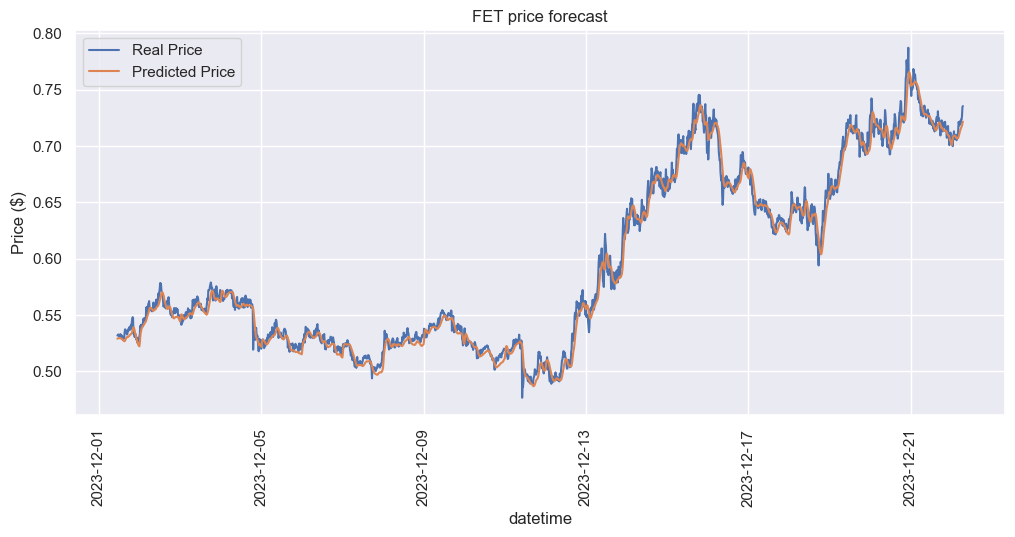

In [34]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(df_pred, x="datetime", y="real_price", label="Real Price")
sns.lineplot(df_pred, x="datetime", y="predicted_price", label="Predicted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()

1/1 [==============================] - 0s 19ms/step


[]

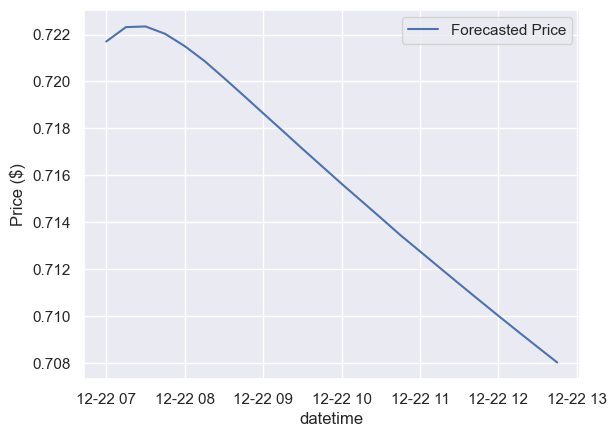

In [35]:
def forecast(data, futur):
    arr = np.expand_dims(data[-1], axis=0)
    #print(data.shape)
    #print(arr.shape)
    L = []
    for _ in range(futur):
        #print("[1]", arr.shape)
        prediction = model.predict(arr)
        #print("[2]", prediction.shape)
        prediction = prediction.reshape(1, 1, num_features)
        #print("[3]", prediction.shape)
        arr = np.append(arr, prediction, axis=1)
        #print("[4]", arr.shape)
        arr = np.delete(arr, 0, axis=1)
        #print("[5]", arr.shape)
        L.append(arr[0][-1])
    return np.array(L)


nb_time = 24
yForecast = forecast(X, nb_time)
yForecast = scaler.inverse_transform(yForecast)[:, 0]
xForecast = range(times[-1], times[-1] + nb_time)

timeDict = {
    "15m" : "15T",
    "1h" : "1H"
}

datetime = pd.date_range(start=df_pred["datetime"].values[-1], periods=nb_time + 1, freq=timeDict[timeframe])[1:]

forecast_dict = {"datetime": datetime, "timestamp": xForecast, "forecasted_price": yForecast}

df_forecast = pd.DataFrame.from_dict(forecast_dict)
df_forecast['datetime'] = pd.to_datetime(df_forecast['datetime'])

sns.lineplot(df_forecast, x="datetime", y="forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.plot()

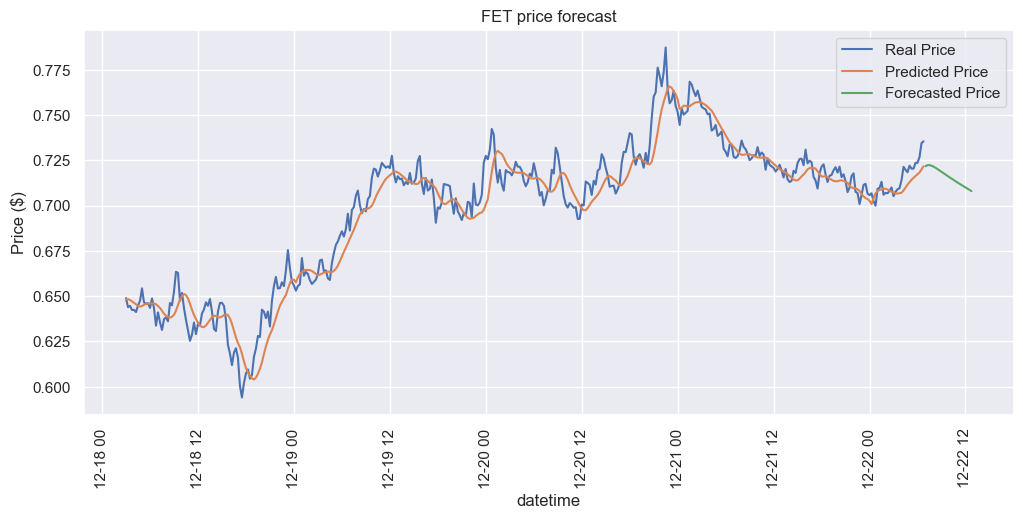

In [36]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(df_pred[-400:], x="datetime", y="real_price", label="Real Price")
sns.lineplot(df_pred[-400:], x="datetime", y="predicted_price", label="Predicted Price")
sns.lineplot(df_forecast, x="datetime", y="forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()